In [92]:
%cd "C:\Users\andrewmauro\Desktop\springboard\Project Excercises\Baseball Data" 

C:\Users\andrewmauro\Desktop\springboard\Project Excercises\Baseball Data


# Initial Outline

Did Yadier Molina improve his home run ability from 2016-2017?

In [ ]:
#packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import time
import scipy.stats as stats
import theano.tensor as tt
import pymc3 as pm
from IPython.core.pylabtools import figsize
import math

In [94]:
batters = pd.read_csv("batters.csv", index_col = 0)
player = batters[batters["batter"] == 425877]
del batters

#aim for even sample size
player.head()

C:\Users\andrewmauro\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,launch_angle_q3,launch_angle_q4,launch_speed_q1,launch_speed_q2,launch_speed_q3,launch_speed_q4,launch_speed_angle_q1,launch_speed_angle_q2,launch_speed_angle_q3,launch_speed_angle_q4
2553,FF,2016-04-06,93.1,NaN,NaN,Yadier Molina,425877,458537,single,hit_into_play_no_out,...,0,0,0,0,1,0,1,0,0,0
2555,FF,2016-04-06,92.1,NaN,NaN,Yadier Molina,425877,458537,NaN,ball,...,0,0,0,0,0,0,0,0,0,0
3218,SL,2016-04-06,93.1,-3.0053,5.3632,Yadier Molina,425877,491708,field_out,hit_into_play,...,0,1,0,0,1,0,0,1,0,0
3232,FT,2016-04-06,101.4,-2.3629,5.2739,Yadier Molina,425877,491708,NaN,ball,...,0,0,0,0,0,0,0,0,0,0
3235,SI,2016-04-06,99.1,-2.6217,5.2589,Yadier Molina,425877,491708,NaN,called_strike,...,0,0,0,0,0,0,0,0,0,0


In [95]:
#set sample
sample = player.shape[0] / 50

#read
#player = pd.read_csv("rendon.csv", index_col = False)

#game date
player['game_date'] = pd.to_datetime(player['game_date'], format = '%Y/%m/%d')

#row count
#reset index
player = player.sort_values('game_date')
player = player.reset_index()
player['segment'] = player.index + 1
player['segment'] = player['segment'] / sample
player['segment'] = player['segment'].transform('ceil').astype('int')

player.tail()


,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,launch_angle_q4,launch_speed_q1,launch_speed_q2,launch_speed_q3,launch_speed_q4,launch_speed_angle_q1,launch_speed_angle_q2,launch_speed_angle_q3,launch_speed_angle_q4,segment
4275,1469355,FF,2018-04-10,85.2,2.8073,6.3244,Yadier Molina,425877,608718,NaN,...,0,0,0,0,0,0,0,0,0,50
4276,1470128,CH,2018-04-10,79.6,2.8432,6.5388,Yadier Molina,425877,608718,NaN,...,0,1,0,0,0,1,0,0,0,50
4277,1470107,FF,2018-04-10,84.8,2.7820,6.4276,Yadier Molina,425877,608718,NaN,...,0,0,0,0,0,0,0,0,0,50
4278,1469377,FF,2018-04-10,84.5,2.6523,6.4050,Yadier Molina,425877,608718,NaN,...,0,0,0,0,0,0,0,0,0,50
4279,1470139,CH,2018-04-10,79.1,2.7740,6.3566,Yadier Molina,425877,608718,NaN,...,0,0,0,0,0,0,0,0,0,50


In [96]:
player = player[[
#general descrip
'game_year',
'game_date',
'segment',
'player_name',
'batter',
'stand',
'description',
'des',
'events',

#batted general
'type',
'hit_location',
'bb_type',
'barrel',

#batted physics
'hc_x',
'hc_y',
'hit_distance_sc',
'launch_speed',
'launch_angle',
'launch_speed_angle',

#batted quartiles
'launch_angle_q1',
'launch_angle_q2',
'launch_angle_q3',
'launch_angle_q4',

'launch_speed_q1',
'launch_speed_q2',
'launch_speed_q3',
'launch_speed_q4',
    
'launch_speed_angle_q1',
'launch_speed_angle_q2',
'launch_speed_angle_q3',
'launch_speed_angle_q4',


#pitcher
'p_throws',
'pitch_name'

]]

In [97]:
player['events'].unique()

array([nan, 'single', 'walk', 'strikeout', 'field_out', 'hit_by_pitch',
       'grounded_into_double_play', 'force_out', 'double', 'double_play',
       'triple', 'intent_walk', 'fielders_choice_out',
       'caught_stealing_2b', 'home_run', 'field_error', 'sac_fly',
       'other_out', 'fielders_choice', 'pickoff_1b',
       'strikeout_double_play', 'sac_bunt', 'triple_play',
       'sac_fly_double_play'], dtype=object)

In [98]:
player['event'] = np.where((player['events'] == 'home_run'), #|
                           #(player['events'] == 'triple') |
                           #(player['events'] == 'double'), |
                           1, 0)

player['event'].sum()

29

    Data appears ok based on the fact that total homers match expectation of 46 (2016 to 2018 4/10)

In [99]:
summary = player.groupby('segment')[['event']].sum()

summary['event'] = summary['event']

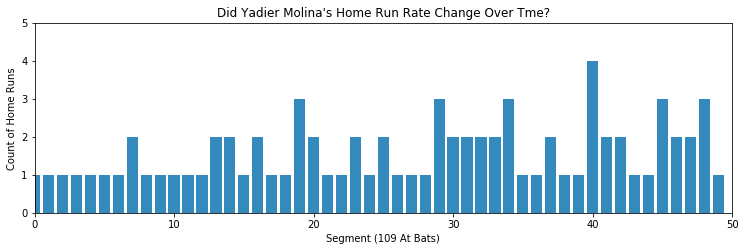

In [100]:
figsize(12.5, 3.5)
n_count_data = len(summary)
plt.bar(np.arange(n_count_data), summary['event'], color="#348ABD")
plt.xlabel("Segment (109 At Bats)")
plt.ylabel("Count of Home Runs")
plt.title("Did Yadier Molina's Home Run Rate Change Over Tme?")
plt.xlim(0, n_count_data);
plt.ylim(0, 5);

## Model the Count of Home Runs

A Poisson random variable is generally an appropriate model for count data, such as home runs. When we model a Poisson random variable, we seek to estimate a parameter lambda. We will also test whether there is any "switchpoint" observable in the data. Notice for instance how there appear to be more Home Runs occuring after segment 25 in our sample. 

Because of our switchpoint, we will actually look to make estimates of two lambda parameters, one before the switchpoint and one afterward. 

In [101]:
alpha = 1.0/summary.mean()[0]

type(alpha)

numpy.float64

In [102]:
#a lambda paramter controls the distribution of a poisson random variable
#the higher lambda is, the larger the average count value will be
#takes a parameter, alpha, which controls its distribution
#we wll suppose that lambda (average count) exhibits a exponential distribution
#generally the expected value of lambda for such a distribution is 1/a
#higher a, lower lambda

with pm.Model() as model:
    #set to expected value based on data observed
    alpha = 1.0/summary.mean()[0]

    #initiate lambda 1 and 2 random variables
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower = 0, upper = n_count_data - 1)

INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '23880')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\andrewmauro\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-3.6.3-64\lock_dir


In [103]:
with model:
    #create an index to compare against each iteration of tau
    idx = np.arange(n_count_data)
    #deterministic variable lambda
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [104]:
#create a Poisson variable called observation.
#we combine our data (count data), with our proposed data generation scheme (lambda_)
with model:
    observation = pm.Poisson("obs", lambda_, observed = summary['event'])

INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '23880')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\andrewmauro\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-3.6.3-64\lock_dir


In [105]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)
    
#using our model, we execute a "learning step" using Markov Chain Monte Carlo simulation
#this will return thousands of random variables from the posterior distributions lambda 1 and lambda 2 and tau
#then we can plot a histogram of what those distributions look like

with model:
    #define learning step
    step = pm.Metropolis()
    #return thousands of random variables from the posterior distributions of our variables of interest
    trace = pm.sample(10000, tune = 5000, step = step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.


In [106]:
##obtain the samples we created above for the purposes of plotting (below)
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

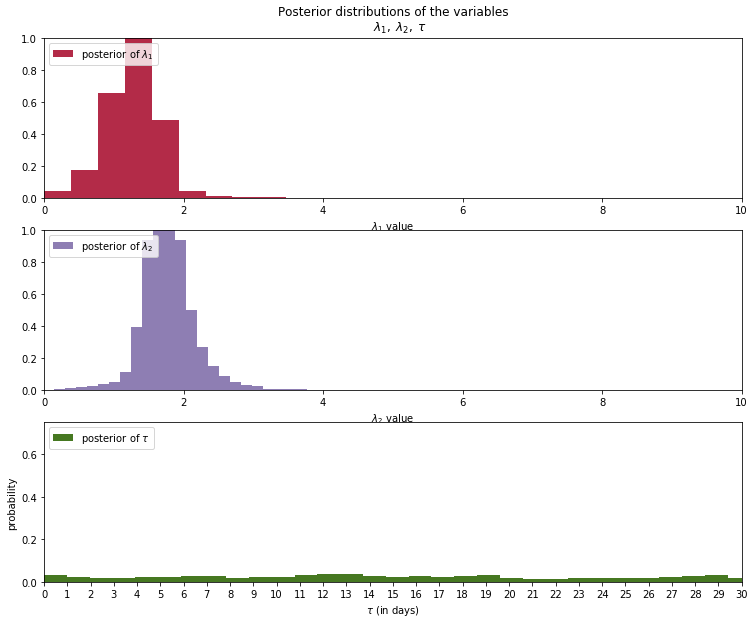

In [107]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 10])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 10])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([0, len(summary)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

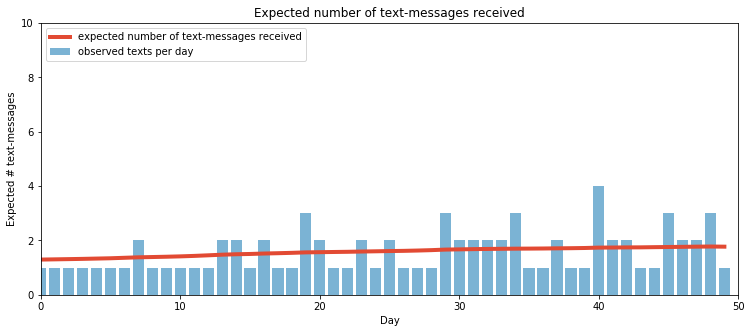

In [108]:
figsize(12.5, 5)
N = tau_samples.shape[0]
expected = np.zeros(n_count_data)
for seg in range(0, n_count_data):
    ix = seg < tau_samples
    expected[seg] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected, lw=4, color="#E24A33",
         label="expected number of Home RUns")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of Home Runs")
plt.ylim(0, 10)
plt.bar(np.arange(len(summary)), summary['event'], color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

In [109]:
print("mean 1: ", lambda_1_samples.mean())
print("mean 2: ", lambda_2_samples.mean())

mean 1:  1.29109080134
mean 2:  1.77096212731


## Conclusion

There is insuffucient evidence that Yadier Molina has improved his ability to hit home runs, based on the analysis above. Our analysis suggests that a window of greater than 50 ABs may be preferable for predicting home runs.